## Workshop notebooks

When working on your solution, you can save your notebook as many times as you like. You can also submit 
as many times as you like. In fact, it is a good idea to save and submit often.

**Only the last submission before the deadline** will be marked.
Note that you have to **submit** at least once for your work to be marked.

The notebook contains cells with code. Some of the code is (intentionally) missing. Please insert appropriate code where it says 'YOUR CODE HERE' and delete or comment out the 'raise NotImplementedError()' statements. Cells which do not contain any 'YOUR CODE HERE' lines will allow you to test your code; if they return an error there is something wrong with your implementation; if they do not return an error your code might be correct (it is unfortunately not possible to check for every possible error).

## Workshop III: Harmonic motion

In this workshop we implement several solvers that integrate the equation of motion of a pendulum.
We consider both a linear pendulum, with friction and driving, and a non-linear pendulum.

The coordinates of the pendulum are the angle measured from the vertical ($\theta$ in the notes, $\phi$ in this notebook), and its time derivative ($\omega={\rm d}\phi/{\rm d}t$). In the implementation below, $\phi$ and $\omega$ are the first and second entry of the state vector $x$:

` x=np.array([phi, omega]) `


** Total marks is out of 14**

In [63]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.getcwd())
from DEq_Solver import DEq_Solver
import solvers  # this file implements the solvers from previous problem 

 
  We will use the `Pendulum` class as a kernel for the normal Euler and Runge-Kutta method and the new Euler-Cromer method. We will implement `dx_dt(self,x,t)` for the former and `dx_dt_EC(self,x,t)` for the latter. You have access to


    self.x        - the state vector
    self.t        - the time
    self.delta_t  - the time step
    
    self.L        - pendulum's length
    self.g        - gravity acceleration
    self.FD       - driving acceleration
    self.OD       - driving frequency
    self.q        - friction coefficient
    self.nolin    - whether pendulum is linear (small angle approximation)


In [64]:
class Pendulum:
    def __init__(self, L, q=0, F_D=0, Omega_D=0, nonlinear=False):
        """Initialize a pendulum object with 
        length L [m], 
        friction coefficient q [], 
        driving acceleration amplitude F_D [N/kg],
        frequency Omega_D [s^-1]. 
        and a switch to enable the nonlinear pendulum"""
        self.L = float(L)
        self.q = float(q)
        self.FD = float(F_D)
        self.OD = float(Omega_D)
        self.nonlin = nonlinear
        self.g = 9.81

    def dx_dt(self,x,t):
        # implement the derivative here! It should include drag and driving forces and 
        # treat both linear or non-linear cases.
        # YOUR CODE HERE
        dx = []
        dx.append(x[1])
        if self.nonlin:
            dx.append(-1 * (self.g / self.L) * np.sin(x[0]) - self.q * x[1] + self.FD * np.sin(self.OD * t))
        else:
            dx.append(-1 * (self.g / self.L) * x[0] - self.q * x[1] + self.FD * np.sin(self.OD * t))
        return np.array(dx)
       
    def analytic(self,phi0,t):
        return phi0 * np.cos(np.sqrt(self.g/self.L) * t)

    def T(self,x):
        ''' This is the kinetic energy'''
        phi = x[0]
        omega = x[1]
        # YOUR CODE HERE
        return 1/2 * self.L ** 2 * omega ** 2 
        
    def U(self,x):
        ''' This is the potential energy '''
        phi = x[0]
        omega = x[1]
        if self.nonlin:
            U=0
            # YOUR CODE HERE
            U = self.g * self.L * (1 - np.cos(phi))
            
        else:
            U=0
            # YOUR CODE HERE
            U = self.g * self.L * phi ** 2 / 2
        return U


The next hidden cell verifies your dx_dt implementation.

** 2 marks **


In [65]:
# this tests the dx_dt implementation
testPend=Pendulum(2.3,1.1,0.5,2.2,False)
testPendNL=Pendulum(2.3,1.1,0.5,2.2,True)
assert np.isclose(testPendNL.dx_dt([0.5,0.3],0.7),[ 0.3, -1.87509123]).all()
assert np.isclose(testPend.dx_dt([0.5,0.3],0.7),[ 0.3, -1.96284578]).all()

The next hidden cell verifies your calculation of the potential and kinetic energy.

** 2 marks **


In [66]:
#this tests the energy implementation
assert np.isclose(testPend.U([0.5,0.3]),2.820375)
assert np.isclose(testPend.T([0.5,0.3]),0.23805)
assert np.isclose(testPendNL.U([0.5,0.3]),2.7621)
assert np.isclose(testPendNL.T([0.5,0.3]),0.23805)

Below we define the Euler-Cromer solver. The class EulerCromerSolver is derived from the more general DEq_Solver class (see DEq_Solver.py in this directory). This means that the resulting EulerCromerSolver class features all the methods defined in DEq_Solver as well as the additional EulerCromerSolver methods which you are supposed to complete below. 

Implement the makeStep(self) function. Within this function you have access to 

- the current coordinates array as ``self.x``
- the current time as ``self.t``
- the derivative $dx/dt$ as ``self.kernel.dx_dt(self.x,self.t)``
- the timestep as ``self.delta_t``

the function ``makeStep`` has to update ``self.x`` and ``self.t``.
 

In [67]:
class EulerCromerSolver(DEq_Solver):
    def __init__(self,kernel):
        self.kernel  = kernel
    def makeStep(self):
        # this should implement the EC step, as before you have access to
        # self.x, self.t , self.delta_t and the derivative as self.kernel.dx_dt_EC
        # YOUR CODE HERE
        dx = self.dx_dt_EC(self.x, self.t)
        self.x[0] += dx[0] * self.delta_t
        self.x[1] += dx[1] * self.delta_t
        self.t += self.delta_t
        
    def dx_dt_EC(self,x,t):
        tmp = self.kernel.dx_dt(x, t)[1]
        dx = []
        dx.append(x[1] + tmp * self.delta_t)
        dx.append(tmp)
        return np.array(dx)

The hidden cell below tests the implementation of the EulerCromer solver. 

** 2 marks**

In [68]:
# this tests the EC step
testEC=EulerCromerSolver(testPend)
testEC.x=[0.3,0.2]
testEC.t=0
testEC.delta_t=0.01
testEC.makeStep()
assert np.isclose(testEC.t,0.01)
assert np.isclose(testEC.x,[ 0.30185004,  0.18500435]).all()

## Application
Evolve linear pendulum, compute and plot angle and energy as a function of time 

In [69]:
def makePlots(solver,
              dt = 0.02,  # time step size
              t0 = 0.,     # start time t1 (s)
              t1 = 100.,   # End time t1 (s)
              phi0 = 15,    # initial angle (deg)
              maxE = 0,     # record the maxinum 
              logscale = False # logscale for energy plot 
             ):
    '''
    This function creates the two plots 
      angle vs time  
      energy vs time
    '''

    # this sets the initial conditions
    x0 = np.array([phi0 * np.pi / 180., 0])

    result = solver.solve(x0, t0, t1, dt)
    ts = solver.timeSteps()
    coords = solver.coordinateSteps()
    rads, omegas = coords   
    degrees = 180. * rads / np.pi
    fig, ax = plt.subplots(1, 2, figsize = (12, 6))

    fig.suptitle('Pendulum. $L$=%s m; $q$=%s/s; $F_D$=%s$/\mathsf{s}^2$, $\Omega_D$=%s/s'
            %(
                solver.kernel.L,
                solver.kernel.q,
                solver.kernel.FD,
                solver.kernel.OD))
    
    #plot angle vs. time
    ax[0].plot(ts, degrees)
    ax[0].set_ylabel(r'$\phi [\mathrm{deg}]$')
    ax[0].set_xlabel(r'$t [\mathrm{s}]$')
    
    Ts = [ pend.T(x) for x in zip(rads,omegas) ]
    Us = [ pend.U(x) for x in zip(rads,omegas)  ]
    Es = [ a + b for a, b in zip(Ts,Us) ]
    print(max(Es))
    ax[1].plot(ts, Ts, 'b', label='$E_{kin}$')
    ax[1].plot(ts, Us, 'g', label='$E_{pot}$')
    ax[1].plot(ts, Es, 'r', label='$E_{tot}$')

    ax[1].set_xlabel('Time [s]')
    ax[1].set_ylabel('Energy [J/kg]')
    if logscale:
        ax[1].set_yscale('log')
    ax[1].legend()    

### Integrate the pendulum using the original Euler method

107339528.39685851


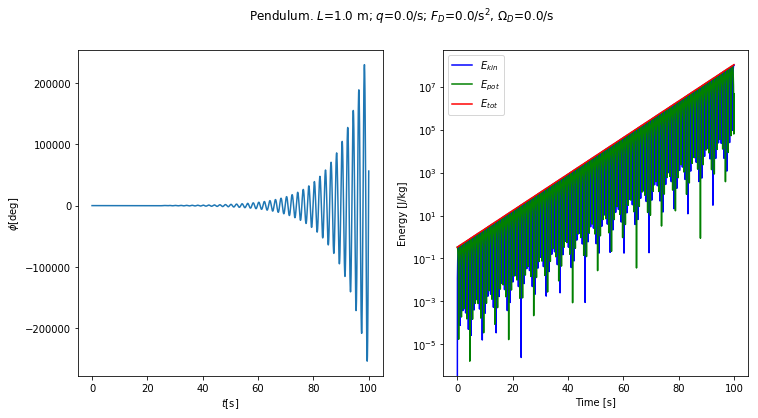

In [70]:
# this show the problem with energy non-conservation
pend = Pendulum(
                L=1.0,
                q=0,
                F_D=0,
                Omega_D=0,
                nonlinear=False)
solver = solvers.EulerSolver(pend)

makePlots(solver, logscale = True)

### Integrate using RK 2

In this part we use the same pendulum model as before, but use the Runge-Kutta solver. It was already implemented in a previous exercise, so it is provided here in the solvers module.

0.3427166550065478


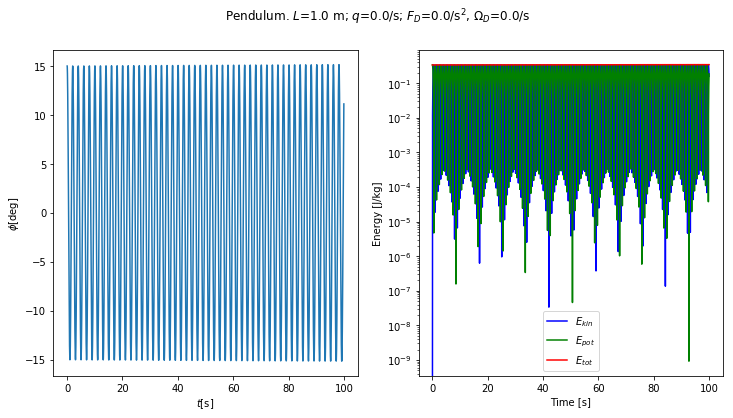

In [71]:
solver = solvers.RK2Solver(pend)
makePlots(solver, logscale=True)

Put a tick mark in the boxes that are true. No tick means answer is false.

** 2 marks **



In [46]:
import mywidgets
from IPython.display import display, HTML
mcb=mywidgets.myCheckBoxSet('Harmonic','RK1',
                            'Which of the following assertions are true?',[
                                'The Runge-Kutta solver performs is more stable than the Euler solver for this problem',
                                'The amplitude grows exponentially for the RK2 solver.',
                                'For $\Delta t=0.001$ the RK2 solver is stable for $t_0=0$ and $t_1=100$.',
                                'The RK2 method is stable for all $t$.'
                            ])
mcb.getWidget()

display(HTML('<hr>'))

### Integrate using RK 4

We repeat the same exercise but using the RK4 solver. It was already implemented in a previous exercise, so it is provided here in the solvers module.

0.3361833999121062
0


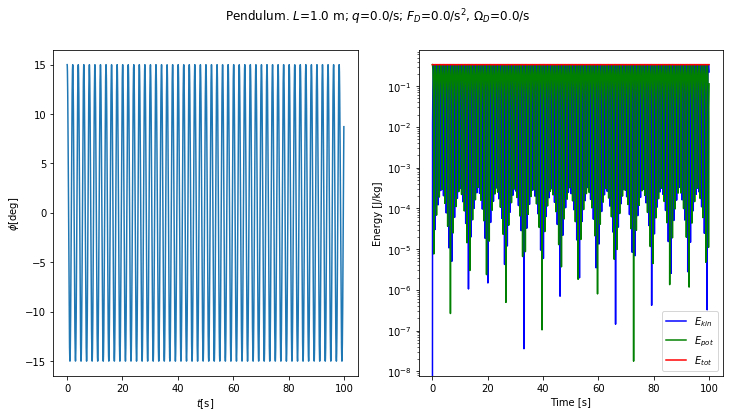

In [51]:
solver = solvers.RK4Solver(pend)
makePlots(solver,logscale=True)

Put a tick mark in the boxes that are true. No tick means answer is false.

**2 marks**

In [47]:
import mywidgets
from IPython.display import display, HTML
mcb2=mywidgets.myCheckBoxSet('Harmonic','RK4',
                            'Which of the following assertions are true?',[
                                'Energy conservation is better for the RK4 solver than for the RK2 solver for the same value of $\delta t$',
                                'The RK4 solver peforms more operations than the RK2 solver for the same number of steps'
                            ])
mcb2.getWidget()

display(HTML('<hr>'))

### Integrate using Euler-Cromer's method

Integrate using your implemntation of Euler-Cromer's solver.

0.3470534180569502
0


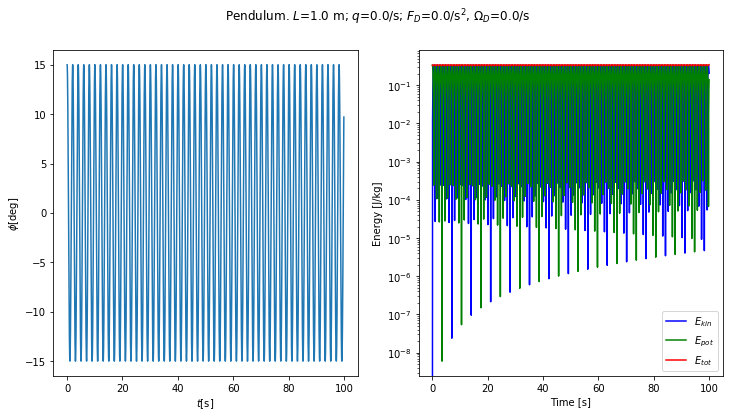

In [49]:
ECsolver = EulerCromerSolver(pend)
makePlots(ECsolver,dt=0.02,t1=100,logscale=True)

In [48]:
import mywidgets
mcb3=mywidgets.myCheckBoxSet('Harmonic','EC',
                            'Which of the following assertions are true?',[
                                'The EC solver is less stable than RK2 for the same number of steps',
                                'The EC solver performs more operations than the RK2 solver for the same number of steps',
                                'The energy of the pendulum oscillates with an amplitude that depends on $\delta t$.',
                            ])
mcb3.getWidget()

display(HTML('<hr>'))

### Integrate non-linear pendulum using Euler-Cromer's method

0.6998088882205137


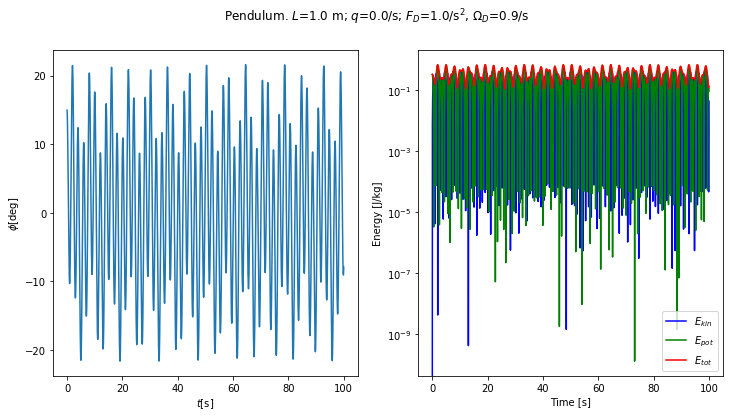

In [94]:
NLpend = Pendulum(
                L=1.0,
                q=0,
                F_D=1,
                Omega_D=0.9,
                nonlinear=True)
ECsolver = EulerCromerSolver(NLpend)
makePlots(ECsolver,dt=0.01,t1=100, logscale=True)

Answer the question below.

**2 marks**

In [49]:
import mywidgets
mfb=mywidgets.myFloatBox('Harmonic','NL','$E_{max}$','What is the maximum energy of the non-linear pendulum NLpend in the first 100 time units if the initial position is 15 degrees and no initial velocity? Give your answer to 3 significant figures.')
mfb.getWidget()

In [50]:
display(HTML('<hr>'))

## Playground

This is another exercise; there are no marks associated with it.
Consider the following modification to the EC-solver, called **leapfrog**

$$ \phi^{n+1} = \phi^n + \omega^{n+1/2} \Delta t$$
$$ \omega^{n+3/2} = \omega^{n+1/2} + f(\phi^n) \Delta t$$


The first line - updating the position given the velocity, is called the **drift**.
The second line - updating the velocity given the acceleration, is called the **kick**.

Notice how position and velocity are always offset by 1/2 of a timestep, $\Delta t$.

Note that, to get started, this requires calculating $\omega^{1/2}$ from the initial velocity, $\omega^0$.

Implement this leapfrog scheme, and check for energy conservation. **Beware**: you need to calculate the potential energy and the kinetic energy **at the same time**. So you will need to perform either 1/2 a drift, or 1/2 a kick.